# Predictive Model for Conversion Rate Prediction
* Business Objective
* Data Collection and Understanding
* Exploratory Data Analysis
* Data Preparation
* Predictive Modeling
* Testing and Evaluation
* Deployment

## 1. Business Objective: 
* The goal of this challenge is to build a model that (1) predicts conversion rate and, (2) based on the model, Come up with recommendations for the product team and the marketing team to improve conversion rate.

## 2. Data Collection and Understanding

In [1]:
# Read in the dataset
import pandas as pd
import numpy as np
import pandas_profiling
data = pd.read_csv('conversion_data.csv')

In [2]:
# Overview for the dataset and variables
pandas_profiling.ProfileReport(data)

Number of variables,6
Number of observations,316200
Total Missing (%),0.0%
Total size in memory,14.5 MiB
Average record size in memory,48.0 B
Numeric,2
Categorical,2
Boolean,2
Date,0
Text (Unique),0
Rejected,0


In [3]:
# Look at a sample of 5 rows of the dataset
data.sample(5)

,country,age,new_user,source,total_pages_visited,converted
304733,UK,34,0,Ads,11,0
247899,US,42,1,Ads,4,0
160038,US,48,1,Seo,6,0
66196,US,36,0,Seo,21,1
15143,China,35,1,Direct,8,0


#### Data Dictionary:
* country : user country based on the IP address 
* age : user age. Self-reported at sign-in step 
* new_user : whether the user created the account during this session or had already an account and simply came back to the site 
* source : marketing channel source
    * Ads: came to the site by clicking on an advertisement
    * Seo: came to the site by clicking on search results
    * Direct: came to the site by directly typing the URL on the browser 
* total_pages_visited: number of total pages visited during the session. This is a proxy for time spent on site and engagement during the session.
* converted: this is our label. 1 means they converted within the session, 0 means they left without buying anything. The company goal is to increase conversion rate: # conversions / total sessions.

In [4]:
# Look at the information for the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [5]:
# Check missing values in the dataset
data.isnull().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

In [6]:
# Check duplicates in the dataset
data.duplicated().sum()

299903

#### Summary from Data Understanding:
* No missing values, and many duplicates
* total_pages_viewed is highly correlated with the conversion rate
* The target variable (converted) is highly imbalanced

## 3. Exploratory Data Analysis:
* Univariate visualization and summary statistics for each field in the raw dataset
* Bivariate visualization and summary statistics for assessing the relationship between each variable in the dataset and the target variable
* Multivariate visualizations to understand interactions between different fields in the data
* Feature Engineering: use domain knowledge to create additional relevant features from the existing raw features in the data, and to increase the predictive power of the learning algorithm

In [7]:
# Import python modules for visualization
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline
seaborn.set_style('whitegrid')

### 3.1 Univariate Analysis

#### 3.1.1 Numerical variables

In [8]:
# Summary for numerical variables
print(data.describe(include=['int64']))

                 age       new_user  total_pages_visited      converted
count  316200.000000  316200.000000        316200.000000  316200.000000
mean       30.569858       0.685465             4.872966       0.032258
std         8.271802       0.464331             3.341104       0.176685
min        17.000000       0.000000             1.000000       0.000000
25%        24.000000       0.000000             2.000000       0.000000
50%        30.000000       1.000000             4.000000       0.000000
75%        36.000000       1.000000             7.000000       0.000000
max       123.000000       1.000000            29.000000       1.000000


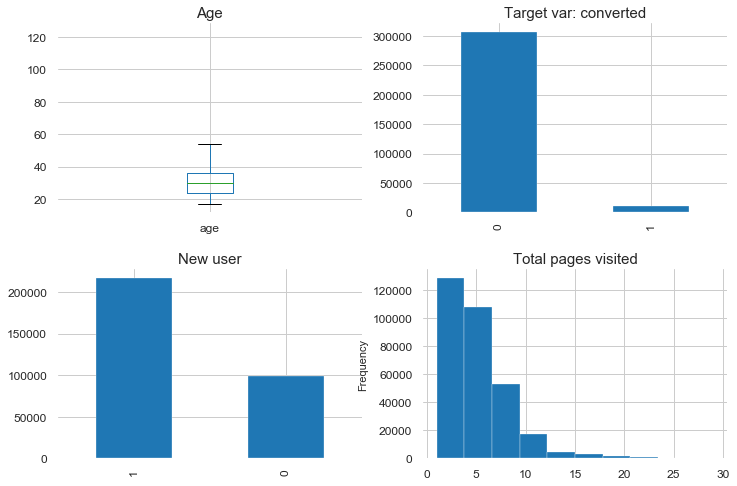

In [9]:
fig, axarr = plt.subplots(2, 2, figsize=(12, 8))

data.age.plot.box(ax=axarr[0][0], fontsize=12)
axarr[0][0].set_title("Age", fontsize=15)

data.new_user.value_counts().plot.bar(ax=axarr[1][0], fontsize=12)
axarr[1][0].set_title("New user", fontsize=15)

data.total_pages_visited.plot.hist(ax=axarr[1][1], fontsize=12)
axarr[1][1].set_title("Total pages visited", fontsize=15)

data.converted.value_counts().plot.bar(ax=axarr[0][1], fontsize=12)
axarr[0][1].set_title("Target var: converted", fontsize=15)

plt.subplots_adjust(hspace=.3)

seaborn.despine()

From the above, we can see: most of the users are younger than 40, and there are some outliers on age (>100) that need to be corrected.

#### 3.1.2 Categorical variables

In [10]:
# Summary for categorical variables
print(data.describe(include=['object']))

       country  source
count   316200  316200
unique       4       3
top         US     Seo
freq    178092  155040


Text(0.5, 1.0, 'Source')

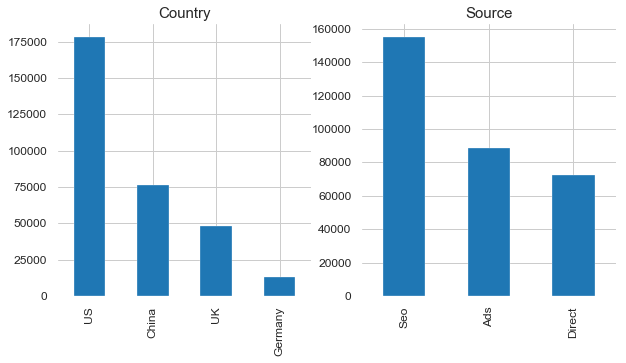

In [11]:
fig, axarr = plt.subplots(1, 2, figsize=(10, 5))

data.country.value_counts().plot.bar(ax=axarr[0], fontsize=12)
axarr[0].set_title("Country", fontsize=15)

data.source.value_counts().plot.bar(ax=axarr[1], fontsize=12)
axarr[1].set_title("Source", fontsize=15)

### 3.2 Feature Engineering

#### 3.2.1 age outlier

In [12]:
print(sorted(data['age'].unique(), reverse=True))

[123, 111, 79, 77, 73, 72, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17]


In [13]:
age_outlier = data[data.age>100]
age_outlier

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


Since there're just 2 rows with the age outliers, we can just drop them.

In [14]:
# drop the rows with age outliers
data1 = data.drop(age_outlier.index, axis=0)
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316198 entries, 0 to 316199
Data columns (total 6 columns):
country                316198 non-null object
age                    316198 non-null int64
new_user               316198 non-null int64
source                 316198 non-null object
total_pages_visited    316198 non-null int64
converted              316198 non-null int64
dtypes: int64(4), object(2)
memory usage: 16.9+ MB


### 3.3 Bivariate and Multivariate Analysis

#### 3.3.1 Bivariate Analysis using pairplot and correlation/heatmap

/Users/cloris1022/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/cloris1022/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


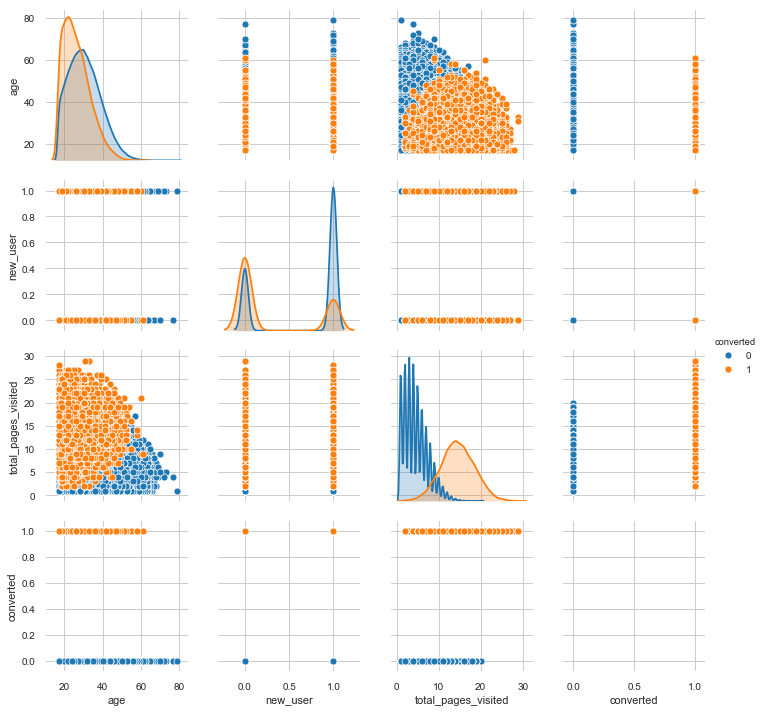

In [15]:
# Bivariate relationship using pair plot
seaborn.pairplot(data1,hue='converted')

In [16]:
# Correlation matrix
data1.corr()

,age,new_user,total_pages_visited,converted
age,1.000000,0.012445,-0.046093,-0.089199
new_user,0.012445,1.000000,-0.082522,-0.152338
total_pages_visited,-0.046093,-0.082522,1.000000,0.528975
converted,-0.089199,-0.152338,0.528975,1.000000


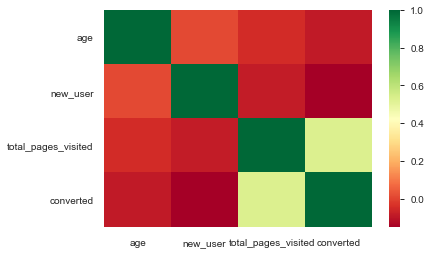

In [17]:
# Heatmap for correlation
seaborn.heatmap(data1.corr(),cmap='RdYlGn')

The conversion rate has high correlation with the total_pages_viewed.

#### 3.3.2 Bivariate relationship with the target variable

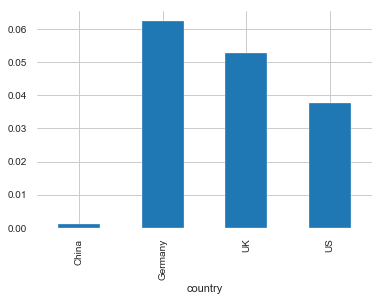

In [18]:
# country vs converted
data1.groupby(['country'])['converted'].mean().plot.bar()
plt.show()

German users have the highest conversion rate, and Chinese users have the lowest conversion rate.

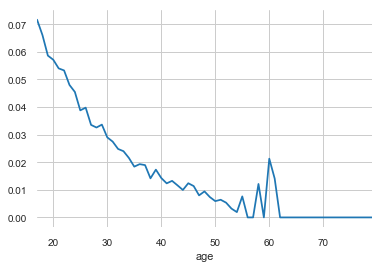

In [19]:
# age vs converted
data1.groupby(['age'])['converted'].mean().plot.line()
plt.show()

Younger users have much higher conversion rate than the elder users.

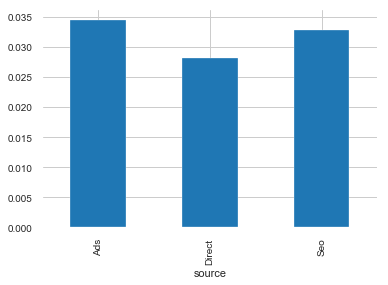

In [20]:
# source vs converted
data1.groupby(['source'])['converted'].mean().plot.bar()
plt.show()

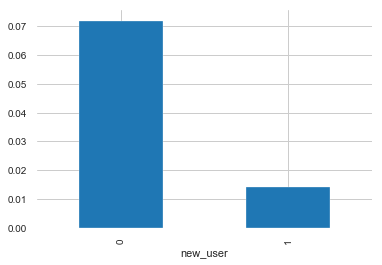

In [21]:
# new_user vs converted
data1.groupby(['new_user'])['converted'].mean().plot.bar()
plt.show()

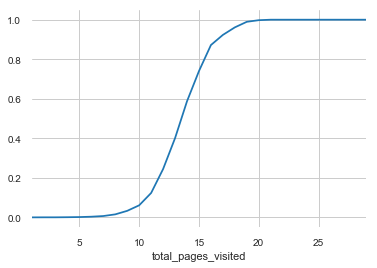

In [22]:
# total pages visited vs converted
data1.groupby(['total_pages_visited'])['converted'].mean().plot.line()
plt.show()

The more pages users spent time on visiting, the higher the conversion rate.

#### 3.3.3 Multivariate relationship among variables

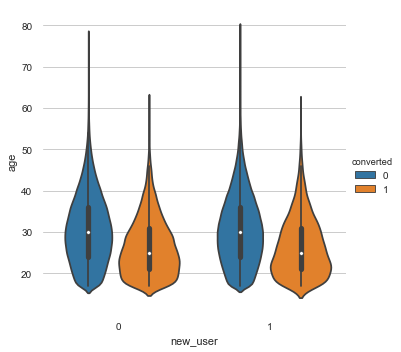

In [23]:
seaborn.catplot(x='new_user', y='age', hue='converted', kind='violin', data=data1)

Younger users convert more than elder users.

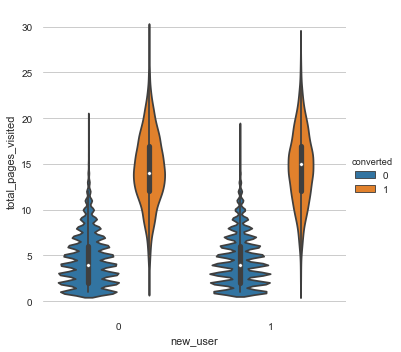

In [24]:
seaborn.catplot(x='new_user', y='total_pages_visited', hue='converted', kind='violin', data=data1)

Users who visit more pages are more likely to convert.

## 4. Data Preparation:
* Data Cleaning: 
    * Check duplicates
    * Fill in missing values if any
    * Get dummies for categorical variables
* Feature Selection / Dimensionality Reduction: to understand the fields in the data that account for the most variance between observations and allow for the processing of a reduced volume of data

### 4.1 Data Cleaning

In [25]:
# Get dummies for the categorical variables
data2 = pd.get_dummies(data1, drop_first = True)
data2.head()

,age,new_user,total_pages_visited,converted,country_Germany,country_UK,country_US,source_Direct,source_Seo
0,25,1,1,0,0,1,0,0,0
1,23,1,5,0,0,0,1,0,1
2,28,1,4,0,0,0,1,0,1
3,39,1,5,0,0,0,0,0,1
4,30,1,6,0,0,0,1,0,1


### 4.2 Feature Selection

In [26]:
# Define training data and target variable - converted
train_data = data2.drop(columns = ['converted'],axis=1)
target = data2['converted']
train_data.shape, target.shape

((316198, 8), (316198,))

In [27]:
# Use random forest classifier for feature selection
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=25, n_estimators=100)
rfc.fit(train_data, target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

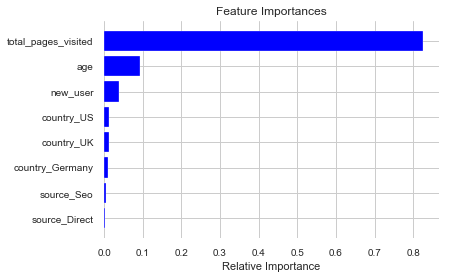

In [28]:
# Look at the top most important features
features = train_data.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)[-9:]  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## 5. Predictive Modeling
* Train-Test split
* For imbalanced data: Re-sampling the data in order to mitigate the effect caused by class imbalance. 
    * The two most common techniques are over-sampling and under-sampling.
* Model selection based on training data
* Model evaluation and Testing

### 5.1 Split training and testing sets

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_data, target, test_size=0.2, random_state=25)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((252958, 8), (63240, 8), (252958,), (63240,))

### 5.2 Re-sampling for Imbalanced data
* Over-sampling increases the number of minority class members in the training set, is preferred and employed more frequently than Under-sampling.
* The most common over-sampling technique is known as SMOTE (Synthetic Minority Over-sampling Technique), but this method can generate noisy samples by interpolating new points between marginal outliers and inliers.
* In this regard, Tomek’s link and edited nearest-neighbours (ENN) are the two cleaning methods that have been added to the pipeline after applying SMOTE over-sampling to obtain a cleaner space.

In [30]:
# Import modules for imbalanced techniques
from collections import Counter
from imblearn.combine import SMOTEENN

In [31]:
# Resample the training data using Smote_ENN technique
smote_enn = SMOTEENN(random_state=0)
X_train_bl, y_train_bl = smote_enn.fit_resample(X_train, y_train)
print(sorted(Counter(y_train_bl).items()))

[(0, 221285), (1, 215834)]


Now the training data is more balanced.

### 5.3 Train model and Algorithm selection

From the data, a Random Forest Classifier and many other algorithms should fit, but let's prove by model selection:

In [32]:
# Import the Classification modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

In [33]:
# Name the models to be used:
algorithms = [RandomForestClassifier(n_estimators=100), ExtraTreesClassifier(n_estimators=100), 
              GradientBoostingClassifier(n_estimators=100), XGBClassifier(n_estimators=100), 
              KNeighborsClassifier(), LogisticRegression(solver='lbfgs'), 
              GaussianNB(), BernoulliNB()]
names = ['RFC', 'ETC', 'GBC', 'XGB', 'KNN', 'LoR', 'GNB', 'BNB']

In [34]:
# Use K-fold cross validation:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=5)

RFC Mean: 0.9997529280483413 ; Std Dev: 0.00020761425208061255
ETC Mean: 0.9998124084134428 ; Std Dev: 0.0001513344319135129
GBC Mean: 0.9791063779139657 ; Std Dev: 0.0031099377405870107
XGB Mean: 0.9787632215649081 ; Std Dev: 0.003069814177390911
KNN Mean: 0.9986822834129591 ; Std Dev: 0.0011178733740734759


/Users/cloris1022/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/cloris1022/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/cloris1022/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/cloris1022/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/cloris1022/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. 

LoR Mean: 0.9781615500734979 ; Std Dev: 0.0030196030816761438
GNB Mean: 0.9721700615261362 ; Std Dev: 0.006652271293752177
BNB Mean: 0.7622067072338864 ; Std Dev: 0.02961410816540006


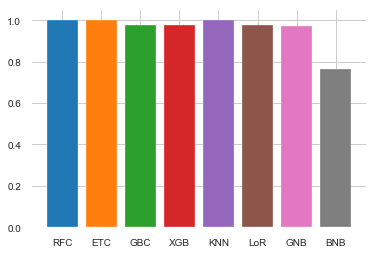

In [35]:
for model, name in zip(algorithms, names):
    cv_results = cross_val_score(model, X_train_bl, y_train_bl, scoring='accuracy', cv=kfold)
    print(name, "Mean:", cv_results.mean(), "; Std Dev:", cv_results.std())
    plt.bar(name, cv_results.mean())

From the above, RFC and ETC algorithms perform better.

### 5.4 Model/Parameter Tuning

In [36]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

#### 5.4.1 Randomized Search Cross Validation

In [38]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 325, 550, 775, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 32, 55, 77, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [39]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 10 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, scoring='accuracy', 
                               cv = 3, verbose=2, random_state=25, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_bl, y_train_bl)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 68.3min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [100, 325, 550, 775, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 32, 55, 77, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=25, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=2)

In [40]:
# View the best parameters from fitting the random search
rf_random.best_params_

{'n_estimators': 775,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 77,
 'bootstrap': True}

#### 5.4.2 Grid Search Cross Validation

In [41]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search.
param_grid = {
    'n_estimators': [700, 800, 900],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt'],
    'max_depth': [70, 80, 90],
    'bootstrap': [True]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, scoring='accuracy', 
                           cv = 3, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
grid_search.fit(X_train_bl, y_train_bl)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 96.5min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 207.9min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [700, 800, 900], 'min_samples_split': [2, 3], 'min_samples_leaf': [1, 2], 'max_features': ['sqrt'], 'max_depth': [70, 80, 90], 'bootstrap': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [42]:
# View the best parameters from fitting the grid search
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 900}

## 6. Testing and Evaluation

### 6.1 Evaluation from Model Tuning

In [43]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report 
from imblearn.metrics import geometric_mean_score, classification_report_imbalanced

In [44]:
# Base model
base_model = RandomForestClassifier(n_estimators = 10, random_state = 25)
base_model.fit(X_train_bl, y_train_bl)
# Apply the algorithm on the test data
y_pred_base = base_model.predict(X_test)
y_pred_base

array([0, 0, 0, ..., 0, 0, 0])

In [45]:
# Model from randomized search
best_random = rf_random.best_estimator_
best_random.fit(X_train_bl, y_train_bl)
# Apply the algorithm on the test data
y_pred_rand = best_random.predict(X_test)
y_pred_rand

array([0, 0, 0, ..., 0, 0, 0])

In [46]:
# Model from randomized search
best_grid = grid_search.best_estimator_
best_grid.fit(X_train_bl, y_train_bl)
# Apply the algorithm on the test data
y_pred_grid = best_grid.predict(X_test)
y_pred_grid

array([0, 0, 0, ..., 0, 0, 0])

### 6.2 View metrics for model performance

In [47]:
# Base model
print('Base model')
print('Accuracy score: ', accuracy_score(y_test, y_pred_base))
print('F1 score: ', f1_score(y_test, y_pred_base))
print('Geometric mean score: ', geometric_mean_score(y_test, y_pred_base))
print('Confusion Matrix: ')
print(confusion_matrix(y_test, y_pred_base)) 
print('Classification report: ')
print(classification_report_imbalanced(y_test, y_pred_base))

Base model
Accuracy score:  0.9549335863377609
F1 score:  0.5523091423185674
Geometric mean score:  0.9088431068016057
Confusion Matrix: 
[[58632  2569]
 [  281  1758]]
Classification report: 
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.96      0.86      0.98      0.91      0.83     61201
          1       0.41      0.86      0.96      0.55      0.91      0.82      2039

avg / total       0.98      0.95      0.87      0.96      0.91      0.83     63240



In [48]:
# Model from randomized search
print('Model from randomized search')
print('Accuracy score: ', accuracy_score(y_test, y_pred_rand))
print('F1 score: ', f1_score(y_test, y_pred_rand))
print('Geometric mean score: ', geometric_mean_score(y_test, y_pred_rand))
print('Confusion Matrix: ')
print(confusion_matrix(y_test, y_pred_rand)) 
print('Classification report: ')
print(classification_report_imbalanced(y_test, y_pred_rand))

Model from randomized search
Accuracy score:  0.9539531941808982
F1 score:  0.5472636815920398
Geometric mean score:  0.9088634921574742
Confusion Matrix: 
[[58568  2633]
 [  279  1760]]
Classification report: 
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.96      0.86      0.98      0.91      0.83     61201
          1       0.40      0.86      0.96      0.55      0.91      0.82      2039

avg / total       0.98      0.95      0.87      0.96      0.91      0.83     63240



In [49]:
# Model from grid search
print('Model from grid search')
print('Accuracy score: ', accuracy_score(y_test, y_pred_grid))
print('F1 score: ', f1_score(y_test, y_pred_grid))
print('Geometric mean score: ', geometric_mean_score(y_test, y_pred_grid))
print('Confusion Matrix: ')
print(confusion_matrix(y_test, y_pred_grid)) 
print('Classification report: ')
print(classification_report_imbalanced(y_test, y_pred_grid))

Model from grid search
Accuracy score:  0.9536369386464263
F1 score:  0.5457080880074372
Geometric mean score:  0.9089586545072417
Confusion Matrix: 
[[58547  2654]
 [  278  1761]]
Classification report: 
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.96      0.86      0.98      0.91      0.83     61201
          1       0.40      0.86      0.96      0.55      0.91      0.82      2039

avg / total       0.98      0.95      0.87      0.96      0.91      0.83     63240



From the above metrics, I will choose the base model, for its (1) higher scores, (2) lower false positives and false negatives.

### 6.3 View Partial Dependence Plot
* Partial dependence plots show how each variable or predictor affects the model's predictions.

In [50]:
from pdpbox import pdp, info_plots

In [54]:
# Convert the array to pandas Dataframe
X_train_pdp = pd.DataFrame({'age':X_train_bl[:,0],'new_user':X_train_bl[:,1], 'total_pages_visited':X_train_bl[:,2], 
                            'country_Germany':X_train_bl[:,3], 'country_UK':X_train_bl[:,4], 'country_US':X_train_bl[:,5], 
                            'source_Direct':X_train_bl[:,6], 'source_Seo':X_train_bl[:,7]})

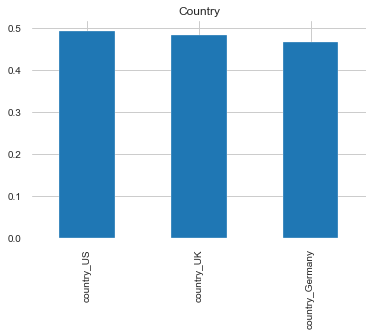

In [55]:
# Country
pdp_iso = pdp.pdp_isolate(model=base_model, 
                          dataset=X_train_pdp,      
                          model_features=list(X_train_pdp), 
                          feature=['country_Germany', 'country_UK', 'country_US'])
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Country')
plt.show()

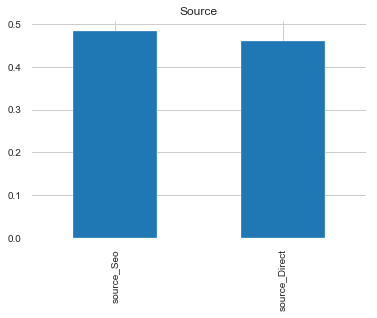

In [56]:
# Source
pdp_iso = pdp.pdp_isolate(model=base_model, 
                          dataset=X_train_pdp,      
                          model_features=list(X_train_pdp), 
                          feature=['source_Direct', 'source_Seo'])
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Source')
plt.show()

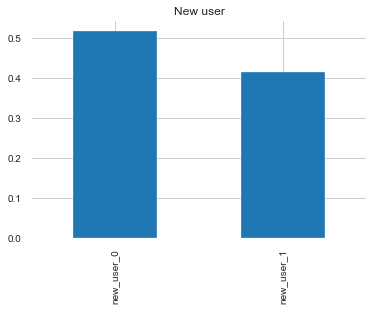

In [57]:
# New user
pdp_iso = pdp.pdp_isolate(model=base_model, 
                          dataset=X_train_pdp,      
                          model_features=list(X_train_pdp), 
                          feature='new_user')
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='New user')
plt.show()

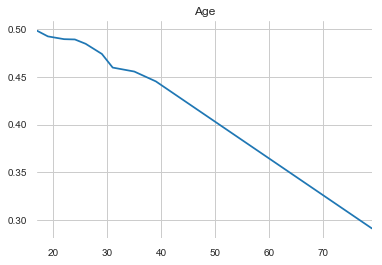

In [58]:
# Age
pdp_iso = pdp.pdp_isolate(model=base_model, 
                          dataset=X_train_pdp,      
                          model_features=list(X_train_pdp), 
                          feature='age')
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
pdp_dataset.plot(title='Age')
plt.show()

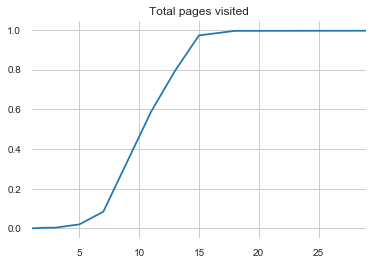

In [59]:
# Total pages visited
pdp_iso = pdp.pdp_isolate(model=base_model, 
                          dataset=X_train_pdp,      
                          model_features=list(X_train_pdp), 
                          feature='total_pages_visited')
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
pdp_dataset.plot(title='Total pages visited')
plt.show()

## 7. Deployment

### 7.1 Convertion rate prediction

In [60]:
# Prediction probability
y_pred_proba = best_grid.predict_proba(X_test)
y_pred_proba

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [61]:
results = pd.DataFrame({
    'Actual conversion': y_test,
    'Predicted conversion': y_pred_grid,
    'prediction_probability_0': y_pred_proba[:,0],
    'prediction_probability_1': y_pred_proba[:,1],
    'new_user': X_test.new_user,
    'age': X_test.age,
    'country_US': X_test.country_US,
    'country_UK': X_test.country_UK,
    'country_Germany': X_test.country_Germany
    }, columns=['Actual conversion', 'Predicted conversion', 'prediction_probability_0',
               'prediction_probability_1', 'new_user', 'age', 'country_US', 'country_UK', 'country_Germany'])

results.head(20)

,Actual conversion,Predicted conversion,prediction_probability_0,prediction_probability_1,new_user,age,country_US,country_UK,country_Germany
219275,0,0,1.000000,0.000000,1,55,1,0,0
146574,0,0,1.000000,0.000000,1,41,1,0,0
230824,0,0,1.000000,0.000000,0,23,1,0,0
37530,0,0,0.993333,0.006667,0,29,0,0,1
167273,0,0,1.000000,0.000000,1,31,1,0,0
170654,0,0,1.000000,0.000000,1,34,0,0,0
28306,0,0,1.000000,0.000000,1,21,0,0,0
12740,0,0,1.000000,0.000000,1,31,1,0,0
108164,0,0,1.000000,0.000000,0,29,1,0,0
226735,0,0,1.000000,0.000000,1,46,0,0,0


### 7.2 Recommendations for the product and marketing team to improve conversion rate

1. Enhance marketing to young people as they have higher conversion rate.
2. Target more on German and UK customers.
3. Return users convert more than new users, use targeted emails to attract conversion.
4. Improve website setting or design for those low converted customers, e.g. older customers and those visited website in China.